In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools as it
import matplotlib.gridspec as gridspec
import scipy as sp

from scipy.spatial.distance import euclidean
from datetime import datetime

%matplotlib inline

In [7]:
experiment_start = datetime(2015, 12, 23, 14, 48, 0)
experiment_end = datetime(2015, 12, 23, 16, 16, 59)

In [8]:
data_columns = ['tracker_id', 'dB', 'year', 'month', 'day', 'hour', 'minute', 'second']

def as_datetime(x):
    return datetime(x.year, x.month, x.day, x.hour, x.minute, x.second)

def read_data(handle):
    
    df = pd.read_csv(handle, header=None)
    df.columns = data_columns
    df['date'] = df.apply(lambda x:as_datetime(x), axis=1)
    df = df[(df['date'] >= experiment_start) & (df['date'] <= experiment_end)]
    return df

def get_id(head, tail):
    """
    Head: the first two letters of the tracker ID.
    Tail: the last two letters of the tracker ID.
    
    Both must be strings.
    """
    
    for t in list(tracker_ids):
        header = t.split(':')[0]
        tailer = t.split(':')[-1]
        
        if header == head and tailer == tail:
            return t
            break

bt1 = read_data('bt1.csv')
bt2 = read_data('bt2.csv')
bt3 = read_data('bt3.csv')
bt4 = read_data('bt4.csv')
bt5 = read_data('bt5.csv')
bt6 = read_data('bt6.csv')

print(len(bt1), len(bt2), len(bt3), len(bt4), len(bt5), len(bt6))

643 1480 1107 1890 1705 1573


In [9]:
tracker_ids = set().union(bt1.tracker_id).union(bt2.tracker_id).union(bt3.tracker_id).union(bt4.tracker_id).union(bt5.tracker_id).union(bt6.tracker_id)
tracker_ids, len(tracker_ids)

({'68:9E:19:11:8E:FD',
  '68:9E:19:11:A3:03',
  '68:9E:19:11:A6:DB',
  'F4:B8:5E:C4:56:22',
  'F4:B8:5E:C4:5F:8C',
  'F4:B8:5E:C4:68:37',
  'F4:B8:5E:C4:8F:EE',
  'F4:B8:5E:DC:B5:DD',
  'F4:B8:5E:DD:42:D2',
  'F4:B8:5E:DD:47:06',
  'F4:B8:5E:DD:47:1B'},
 11)

In [10]:
coords = dict()
coords['BT1'] = (49, 0) # x, y
coords['BT2'] = (-49, 0)
coords['BT3'] = (0, 49)
coords['BT4'] = (0, -1) # at x=0, y=-1
coords['BT5'] = (0, -1)
coords['BT6'] = (0, -1)

coords[get_id('F4', '06')] = (0, 0)
coords[get_id('F4', '37')] = (6, 0)
coords[get_id('68', 'DB')] = (12, 0)
coords[get_id('F4', '8C')] = (24, 0)
coords[get_id('F4', '22')] = (48, 0)
coords[get_id('F4', '1B')] = (0, 12)
coords[get_id('F4', 'EE')] = (0, 24)
coords[get_id('68', '03')] = (0, 36)
coords[get_id('68', 'FD')] = (0, 48)

In [12]:
bt1['distance'] = bt1.apply(lambda x: euclidean(coords['BT1'], coords[x.tracker_id]) if x.tracker_id in coords.keys() else None, axis=1)
bt2['distance'] = bt2.apply(lambda x: euclidean(coords['BT2'], coords[x.tracker_id]) if x.tracker_id in coords.keys() else None, axis=1)
bt3['distance'] = bt3.apply(lambda x: euclidean(coords['BT3'], coords[x.tracker_id]) if x.tracker_id in coords.keys() else None, axis=1)
bt4['distance'] = bt4.apply(lambda x: euclidean(coords['BT4'], coords[x.tracker_id]) if x.tracker_id in coords.keys() else None, axis=1)
bt5['distance'] = bt5.apply(lambda x: euclidean(coords['BT5'], coords[x.tracker_id]) if x.tracker_id in coords.keys() else None, axis=1)
bt6['distance'] = bt6.apply(lambda x: euclidean(coords['BT6'], coords[x.tracker_id]) if x.tracker_id in coords.keys() else None, axis=1)

In [14]:
bt1.head()

,tracker_id,dB,year,month,day,hour,minute,second,date,distance
1642,F4:B8:5E:C4:5F:8C,-84,2015,12,23,14,48,16,2015-12-23 14:48:16,25.000000
1643,F4:B8:5E:C4:56:22,-75,2015,12,23,14,48,16,2015-12-23 14:48:16,1.000000
1644,F4:B8:5E:C4:68:37,-86,2015,12,23,14,48,16,2015-12-23 14:48:16,43.000000
1645,68:9E:19:11:A6:DB,-85,2015,12,23,14,48,16,2015-12-23 14:48:16,37.000000
1646,F4:B8:5E:DD:47:1B,-91,2015,12,23,14,48,47,2015-12-23 14:48:47,50.447993


In [151]:
# Gather together all of the distance measurements, 
distance_measurements = dict()
for df in [bt1, bt2, bt3, bt4, bt5, bt6]:
    for g, d in df.set_index('date').groupby('distance'):
        if g not in list(distance_measurements.keys()):
            distance_measurements[g] = pd.rolling_mean(d['dB'], window=30)
        else:
            distance_measurements[g] = distance_measurements[g].append(pd.rolling_mean(d['dB'], window=30))
            distance_measurements[g].reset_index(inplace=True, drop=True)

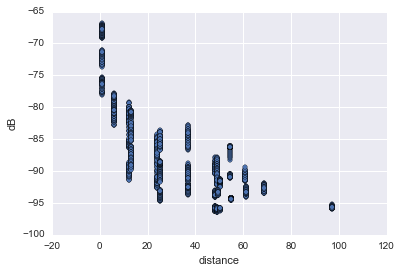

In [155]:
combined = pd.DataFrame()
for distance, dB in distance_measurements.items():
    d = pd.DataFrame(dB)
    d['distance'] = distance
    combined = combined.append(d)
    combined.dropna(inplace=True)
combined.plot(x='distance', y='dB', kind='scatter')

In [166]:
# This is the function that fits dB vs. distance
def paper_func(d, n, A):
    """
    Reference: http://www.rn.inf.tu-dresden.de/dargie/papers/icwcuca.pdf
    """
    return - (10 * n) * np.log10(d) - A

In [192]:
import pymc3 as pm
from theano import tensor

with pm.Model() as model:
    
    n = pm.Normal('n', mu=1, sd=1)
    # n = pm.Uniform('n', lower=0, upper=100)
    A = pm.Normal('A', mu=70, sd=1)
    # A = pm.Uniform('A', lower=0, upper=100)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    
    likelihood = pm.Normal('dB', 
                           mu=paper_func(combined.dropna()['distance'], n, A),
                           sd=sigma,
                           observed=combined.dropna()['dB'])

In [201]:
with model:
    start = {'A':70, 'n':1, 'sigma':10}
    step = pm.NUTS()
    trace = pm.sample(2000, step, start=start)

 [-----------------100%-----------------] 2000 of 2000 complete in 7.8 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138ab7128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x138f06ac8>]], dtype=object)

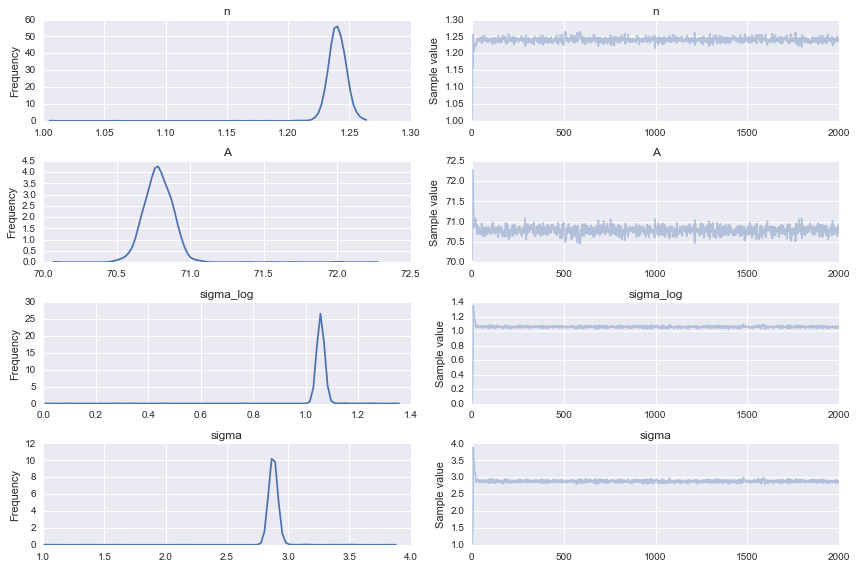

In [202]:
pm.traceplot(trace)

# Next up

* Write model to probabilistically back-infer distance from dB strength. Give 95% distance range.
* Write code to compute all distances over time.